<a href="https://colab.research.google.com/github/fredericpoitevin/tseries-deconvolution/blob/master/Deconvolving_causal_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We are interested in the following scenario:
We have access to two cumulative time-series that we call cause (or _cases_ $C(t)$ the total number of cases at time $t$) and consequence (or _deaths_ $D(t) $ the total number of deaths at time $t$). We assume that consequence is cause convolved with an unknown kernel $K$, and we are interested in inferring the kernel function, or at least its parameters.

Formally, 

$$\frac{\partial D}{\partial \tau}|_{\tau=t} = \sum_{s=0}^{t} K(t-s)\frac{\partial C}{\partial \tau}|_{\tau=s}$$

We have access to samples of the cumulative time-series at fixed time intervals $\Delta t$, we can thus discretize the above equation with finite difference. For $i \geq 1$, we introduce $f_{i} = \frac{F(i\Delta t) - F((i-1)\Delta t)}{\Delta t}$:

$$d_{i} = \sum_{j=1}^{i}k_{ij}c_{j}$$

# Illustrative example

For now we assume that $c$ and $k$ are gaussian and we look at $d$:

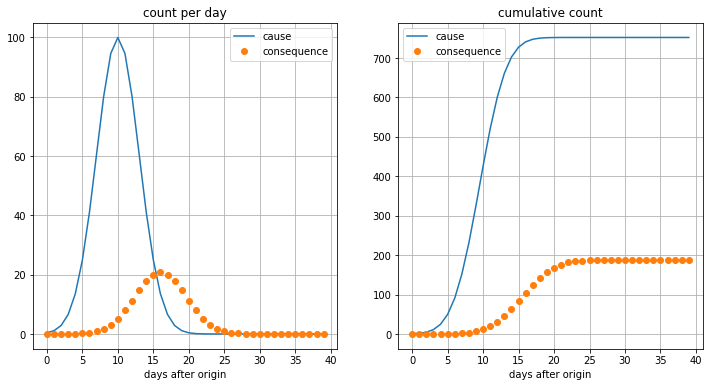

In [143]:
import numpy as np
from matplotlib import pyplot as plt
ndays=40
i = np.arange(-ndays,ndays)
c = build_c(i, mode='gaussian', params=[100,10,3])
k = build_k(i, mode='gaussian', params=[0.25,5,2])
d = build_d(i, cause=c, kernel=k)
display(ndays,c=c,d=d)

If we know the kernel, we can deconvolve:

(80,) (80,)


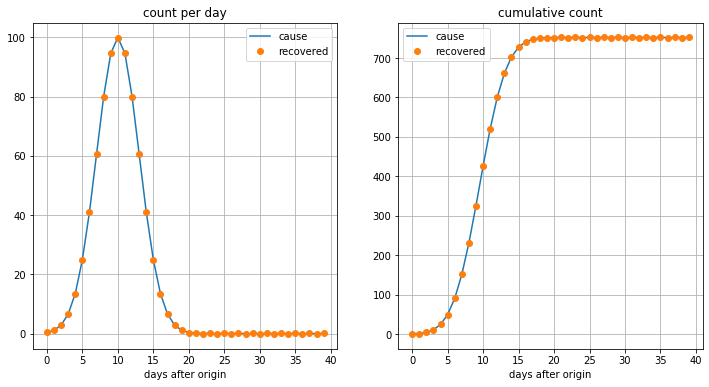

In [144]:
d_fft = np.fft.fft(d)
k_fft = np.fft.fft(k)
c_recovered_fft = d_fft/k_fft
c_recovered = np.roll(np.real(np.fft.ifft(c_recovered_fft)),ndays-1)
display(ndays,c=c,d=c_recovered, labels=['cause', 'recovered'])

In principle, knowing the cause and the consequence, we can retrieve the kernel. Here to deal with divide by zero, we use a Wiener filtering approach to deconvolving:



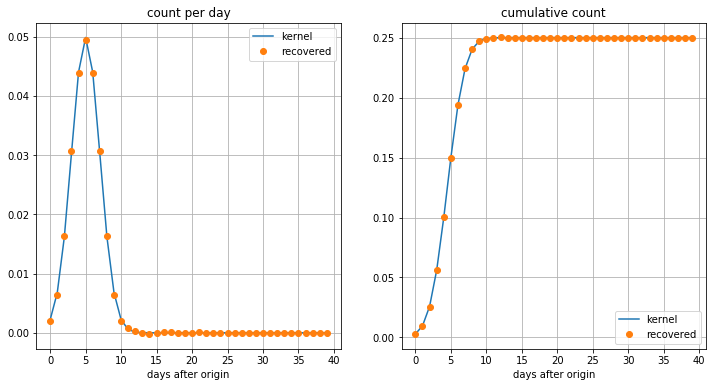

In [150]:
d_fft = np.fft.fft(d)
c_fft = np.fft.fft(c)
k_recovered_fft = d_fft*np.conj(c_fft)/(np.abs(c_fft)**2+0.1)
k_recovered = np.roll(np.real(np.fft.ifft(k_recovered_fft)),ndays-1)
display(ndays,c=k,d=k_recovered, labels=['kernel', 'recovered'])

# Toolkit

In [0]:
def build_c(i, mode='gaussian', params=None):
  """build_c
  """
  if params is None:
    print('ERROR. no param given...')
  else:
    if(mode=='gaussian'):
      amplitude = params[0]
      t_origin  = params[1]
      t_spread  = params[2]
      c = amplitude*np.exp(-(i-t_origin)**2/(2*t_spread**2))
    return c

def build_k(i, mode='gaussian', params=None):
  """build_k
  """
  if params is None:
    print('ERROR. no param given...')
  else:
    if(mode=='gaussian'):
      amplitude = params[0]/(np.sqrt(2*np.pi)*params[2])
      t_origin  = params[1]
      t_spread  = params[2]
      k = amplitude*np.exp(-(i-t_origin)**2/(2*t_spread**2))
    return k

def build_d(i, cause=None, kernel=None):
  """build_d
  """
  if cause is not None:
    if kernel is not None:
      d = np.convolve(k,c,mode='same')
      return d

def display(ndays,c=None, d=None, labels=['cause', 'consequence']):
  trange=np.arange(ndays)
  tzero = ndays
  fig = plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.title('count per day')
  plt.xlabel('days after origin')
  if c is not None:
    plt.plot(trange,c[tzero:], label=labels[0])
  if d is not None:
    plt.plot(trange,d[tzero:], 'o', label=labels[1])
  plt.grid()
  plt.legend()
  plt.subplot(1,2,2)
  plt.title('cumulative count')
  plt.xlabel('days after origin')
  if c is not None:
    plt.plot(trange,np.cumsum(c)[tzero:], label=labels[0])
  if d is not None:
    plt.plot(trange,np.cumsum(d)[tzero:], 'o', label=labels[1])
  plt.grid()
  plt.legend()